# Mind-the-Gap Index

Notebook to test the Mind-The-Gap Index using currently available data.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download data

### Municipality boundaries

In [4]:
mun_schema = 'metropolis'
mun_folder = 'metro_list'

city = 'Guadalajara'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(10, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,14002,14,002,Acatlán de Juárez,"POLYGON ((-103.65448 20.50346, -103.65200 20.5...",Guadalajara
1,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7...",Guadalajara


## AGEB population by hexagon

In [5]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())

In [6]:
# donwload hexagons with pop data
hex_pop = gpd.GeoDataFrame()
hex_folder = 'hex_bins_pop_2020'
hex_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_pop = pd.concat([hex_pop, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_pop.shape)
hex_pop.head(2)

(1187, 225)


,geometry,hex_id_8,CVEGEO,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
0,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8849abc9ebfffff,14002,273.168550,135.64044,137.528090,13.123595,6.831461,6.292135,260.044950,...,13.662921,66.06741,34.426968,56.808990,9.168539,7.011236,2.067416,4.134831,33.348316,0.539326
1,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8849abc9e3fffff,14002,98.333336,46.00000,43.333332,4.666666,2.333333,2.333333,84.666664,...,3.000000,22.00000,11.000000,18.666666,3.000000,2.000000,0.000000,0.000000,9.333333,0.000000


## 15 min cities

In [12]:
# donwload hexagons with time data
hex_time = gpd.GeoDataFrame()
hex_folder = 'time_15_min_analysis_hexres8'
hex_schema = 'prox_analysis'


# Download time data for city
query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_time = aup.gdf_from_query(query, geometry_col='geometry')

print(hex_time.shape)
hex_time.head(2)

(1187, 30)


,hex_id_8,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city
0,8849abc9ebfffff,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",24.705283,24.705283,23.051588,20.315681,51.182696,40.473661,51.182696,22.870778,...,358.203036,273.168550,135.64044,137.528090,75.146068,48.988765,117.932583,31.101124,3.153691,Guadalajara
1,8849abc9e3fffff,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",40.805866,40.686460,40.805866,35.954972,49.267035,47.308015,49.267035,40.606266,...,349.975770,98.333336,46.00000,43.333332,26.666666,19.333333,40.666668,2.666667,1.135241,Guadalajara


## Data Treatment

In [15]:
hex_pop_ind = hex_pop[['hex_id_8','pobtot','p_12ymas','graproes','pder_ss','pea',
                      'vivtot','tvivparhab','ocupvivpar','prom_ocup','pro_ocup_c',
                      'vph_pisoti','vph_s_elec','vph_aguafv','vph_nodren','vph_excsa',
                      'vph_inter','geometry']].copy()
print(hex_pop_ind.shape)
hex_pop_ind.head(4)

(1187, 18)


,hex_id_8,pobtot,p_12ymas,graproes,pder_ss,pea,vivtot,tvivparhab,ocupvivpar,prom_ocup,pro_ocup_c,vph_pisoti,vph_s_elec,vph_aguafv,vph_nodren,vph_excsa,vph_inter,geometry
0,8849abc9ebfffff,273.168550,212.40450,8.860000,218.78651,131.056180,83.325840,72.179780,273.168550,3.780000,1.060000,0.359551,0.269663,1.168539,1.348315,70.561800,34.426968,"POLYGON ((-103.61319 20.42802, -103.61772 20.4..."
1,8849abc9e3fffff,98.333336,68.00000,8.430644,68.00000,42.333332,29.666666,22.666666,89.333336,3.579390,1.026576,0.000000,0.000000,0.000000,0.000000,22.666666,11.000000,"POLYGON ((-103.61374 20.43321, -103.61319 20.4..."
2,8849abc999fffff,60.000000,48.00000,8.645000,47.00000,27.000000,31.999998,14.000000,60.000000,4.284500,1.279000,0.000000,0.000000,0.000000,0.000000,14.000000,9.000001,"POLYGON ((-103.64928 20.44809, -103.65381 20.4..."
3,8849abc9e7fffff,1247.971700,984.30505,9.245727,971.08480,577.124270,406.333300,337.282470,1247.971700,3.700087,0.958633,1.542373,0.000000,2.423729,0.000000,336.180760,172.271200,"POLYGON ((-103.59961 20.43722, -103.60414 20.4..."


In [19]:
hex_time_ind = hex_time[['hex_id_8','max_preescolar','max_primaria',
                         'max_secundaria','max_salud']].copy()
print(hex_time_ind.shape)
hex_time_ind.head(4)

(1187, 5)


,hex_id_8,max_preescolar,max_primaria,max_secundaria,max_salud
0,8849abc9ebfffff,24.705283,23.051588,20.315681,40.473661
1,8849abc9e3fffff,40.686460,40.805866,35.954972,47.308015
2,8849abc999fffff,18.294332,25.496011,100.417806,31.854511
3,8849abc9e7fffff,18.711042,13.808051,18.252167,30.565707


In [20]:
hex_ind = hex_pop_ind.merge(hex_time_ind, on='hex_id_8')
hex_ind.head(2)

,hex_id_8,pobtot,p_12ymas,graproes,pder_ss,pea,vivtot,tvivparhab,ocupvivpar,prom_ocup,...,vph_s_elec,vph_aguafv,vph_nodren,vph_excsa,vph_inter,geometry,max_preescolar,max_primaria,max_secundaria,max_salud
0,8849abc9ebfffff,273.168550,212.4045,8.860000,218.78651,131.056180,83.325840,72.179780,273.168550,3.78000,...,0.269663,1.168539,1.348315,70.561800,34.426968,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",24.705283,23.051588,20.315681,40.473661
1,8849abc9e3fffff,98.333336,68.0000,8.430644,68.00000,42.333332,29.666666,22.666666,89.333336,3.57939,...,0.000000,0.000000,0.000000,22.666666,11.000000,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",40.686460,40.805866,35.954972,47.308015


## Data analysis

### Personas por cuarto

<AxesSubplot:>

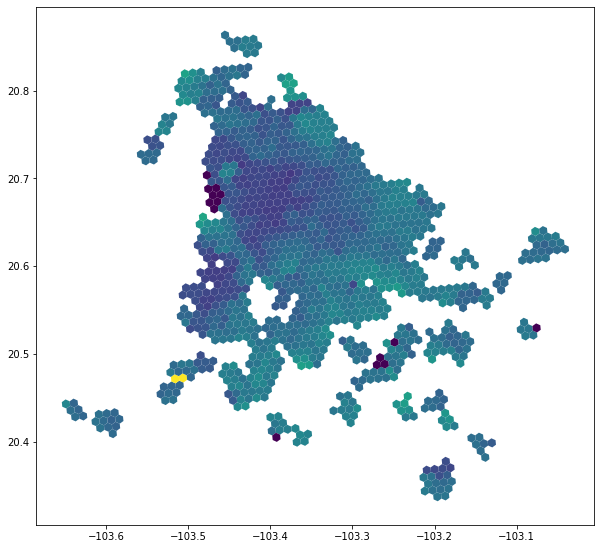

In [23]:
fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('pro_ocup_c', ax=ax)

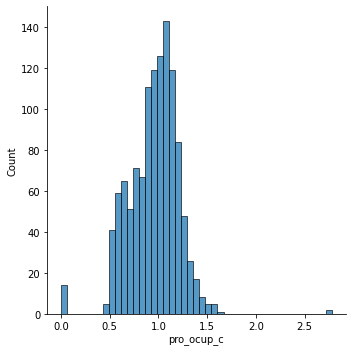

In [28]:
sns.displot(hex_ind['pro_ocup_c'])

### Grado escolaridad

<AxesSubplot:>

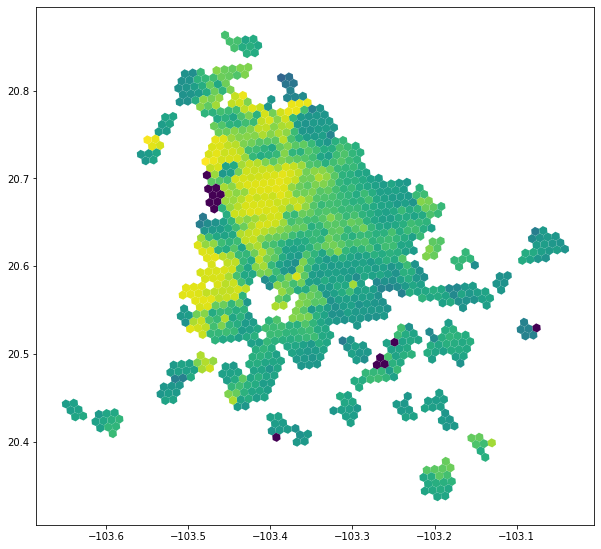

In [29]:
fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('graproes', ax=ax)

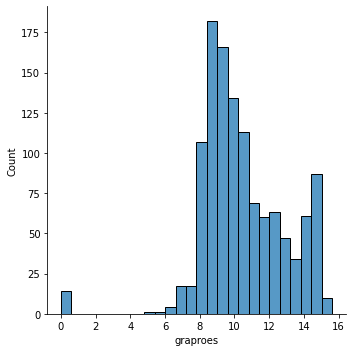

In [30]:
sns.displot(hex_ind['graproes'])

### Tasa de empleo

<AxesSubplot:>

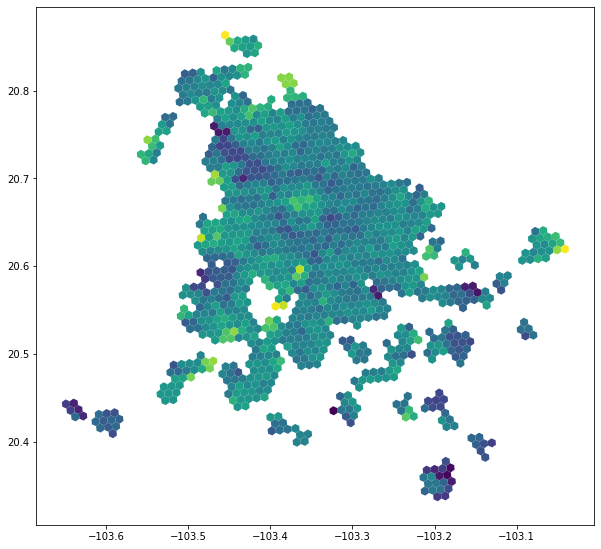

In [31]:
hex_ind['tasa_empleo'] = hex_ind['pea'] / hex_ind['p_12ymas']

fig,ax = plt.subplots(figsize=(10,10))

hex_ind.plot('tasa_empleo', ax=ax)

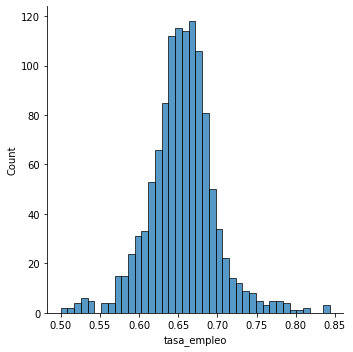

In [32]:
sns.displot(hex_ind['tasa_empleo'])